### How are citations resulting from a failure to stop at either a STOP SIGN or RED LIGHT distributed throughout the day?  How are they distributed by gender?

#### For this analysis I have narrowed the 'Citations' dataset to only those with a 'Charge Description' of *Fail to Stop at Stop Sign* and *Fail to Stop For Red Signal*.  This results in a total of 2,107 observations.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pyodbc
import pandas as pd
import seaborn as sns
import datetime
plt.rcParams["figure.figsize"] = [15, 7]
pd.set_option('display.max_columns', None)

# databaseConnection = 'DRIVER={SQL Server}; SERVER=ServerName; Database=DatbaseName; UID=UserId; PWD=password;'
connection = pyodbc.connect('DRIVER={SQL Server};SERVER=WINDOWS-A6S01I2\SQLEXPRESS;DATABASE=City_of_Scottsdale;Trusted_Connection=yes;')
cursor = connection.cursor()

# SQL query to import all citation data
citations = '''
  select * from [dbo].[spd_PDCitations$]  
  '''
citations = pd.read_sql(citations, connection)
connection.close()

citations['Month'] = citations['Citation Date'].dt.month
citations['Day_of_Month'] = citations['Citation Date'].dt.day

citations['Day_of_Week'] = citations['Citation Date']. \
    apply(lambda x: x.strftime('%a')) #format Citation Day to represent day of week(Mon, Tu, Wed, ect.)

citations['Hour_of_Day'] = citations['Citation Time']. \
    apply(lambda x: str(x)[-7:-4]) # extract the hour of the day from the datetime column
citations['Hour_of_Day'] = pd.to_numeric(citations['Hour_of_Day'],errors='coerce')

#filter for only citations indicative of "failure to stop"
searchfor = [
    'Fail to Stop at Stop Sign',
    'Fail to Stop For Red Signal'
    ]

fail_to_obey = citations[citations['Charge Description'].str.contains('|'.join(searchfor))]

fail_to_obey = fail_to_obey[fail_to_obey['Cited Person Sex'] != 'U'] # remove one instance of person with gender not M or F

# vehicular_accidents
fail_to_obey.head()

,tcmainid,Citation #,Citation Date,Citation Time,Arizona Statute Code,Charge Description,Citation Type Code,Citation Type Description,Officer Badge #,Street Number,Street,City,State,Zip,District,Beat,Zone,Cited Person,Cited Person Age,Cited Person Race,Cited Person Sex,Cited Person Ethnicity,Month,Day_of_Month,Day_of_Week,Hour_of_Day
11,622046.0,2060090.0,2018-06-22,1630.0,28-645A3A,Fail to Stop For Red Signal,CV,Civil Traffic,1180.0,xxx,E Hualapai DR / N Pima Rd,Scottsdale,AZ,NaN,D4,19.0,3801.0,"Delnero, David",41.0,W,M,U,6,22,Fri,16.0
20,593348.0,8083616.0,2017-10-20,808.0,28-855B,Fail to Stop at Stop Sign,CV,Civil Traffic,874.0,xxx,N Hayden Rd / E Westland DR,Scottsdale,AZ,NaN,D4,20.0,4502.0,"Mendivil, Emilio",26.0,W,M,H,10,20,Fri,8.0
21,593349.0,2045722.0,2017-10-26,441.0,28-645A3A,Fail to Stop For Red Signal,CV,Civil Traffic,1415.0,xxx,E Camelback Rd / N Miller Rd,Scottsdale,AZ,NaN,D2,6.0,906.0,"Shuey, Paul",57.0,W,M,N,10,26,Thu,4.0
39,593367.0,2004416.0,2017-10-19,1515.0,28-645A3A,Fail to Stop For Red Signal,CV,Civil Traffic,1202.0,8xxx,E Chaparral Rd,Scottsdale,AZ,NaN,D2,5.0,1106.0,"Temunovic, Bojan",23.0,W,M,N,10,19,Thu,15.0
61,593392.0,2015969.0,2017-10-19,857.0,28-855B,Fail to Stop at Stop Sign,CV,Civil Traffic,801.0,xxx,E 2nd St / N Marshall Wy,Scottsdale,AZ,NaN,D2,7.0,805.0,"Cortas, Tania",37.0,W,F,N,10,19,Thu,8.0


In [3]:
fail_to_obey_hr_day = fail_to_obey.groupby(['Hour_of_Day', 'Charge Description']) \
    .count().sort_values(by='Hour_of_Day', ascending=True).unstack()
                                                                           
fail_to_obey_hr_day.head()

tcmainid                            \
Charge Description Fail to Stop For Red Signal Fail to Stop at Stop Sign   
Hour_of_Day                                                                
1.0                                         32                        15   
2.0                                         23                         7   
3.0                                          7                         4   
4.0                                          8                         2   
5.0                                          8                         4   

                                    Citation #                            \
Charge Description Fail to Stop For Red Signal Fail to Stop at Stop Sign   
Hour_of_Day                                                                
1.0                                         32                        15   
2.0                                         23                         7   
3.0                                          7                         4   
4.0                                          8                         2   
5.0                                          8                         4   

                                 Citation Date                            \
Charge Description Fail to Stop For Red Signal Fail to Stop at Stop Sign   
Hour_of_Day                                                                
1.0                                         32                        15   
2.0                                         23                         7   
3.0                                          7                         4   
4.0                                          8                         2   
5.0                                          8                         4   

                                 Citation Time                            \
Charge Description Fail to Stop For Red Signal Fail to Stop at Stop Sign   
Hour_of_Day                                                                
1.0                                         32                        15   
2.0                                         23                         7   
3.0                                          7                         4   
4.0                                          8                         2   
5.0                                          8                         4   

                          Arizona Statute Code                            \
Charge Description Fail to Stop For Red Signal Fail to Stop at Stop Sign   
Hour_of_Day                                                                
1.0                                         32                        15   
2.0                                         23                         7   
3.0                                          7                         4   
4.0                                          8                         2   
5.0                                          8                         4   

                              ...                       Cited Person Sex  \
Charge Description            ...            Fail to Stop For Red Signal   
Hour_of_Day                   ...                                          
1.0                           ...                                     32   
2.0                           ...                                     23   
3.0                           ...                                      7   
4.0                           ...                                      8   
5.0                           ...                                      8   

                                                  Cited Person Ethnicity  \
Charge Description Fail to Stop at Stop Sign Fail to Stop For Red Signal   
Hour_of_Day                                                                
1.0                                       15                          32   
2.0                                        7                          23   
3.0 

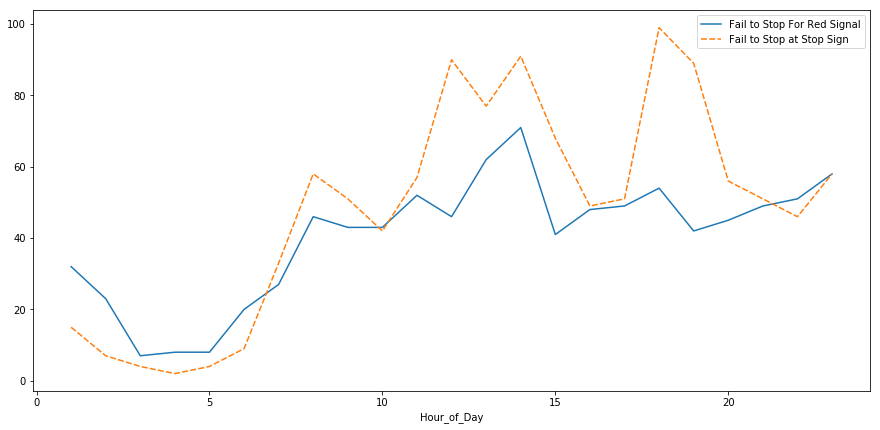

In [6]:
sns.lineplot(data=fail_to_obey_hr_day['Citation #'])
plt.rcParams["figure.figsize"] = [15, 7]

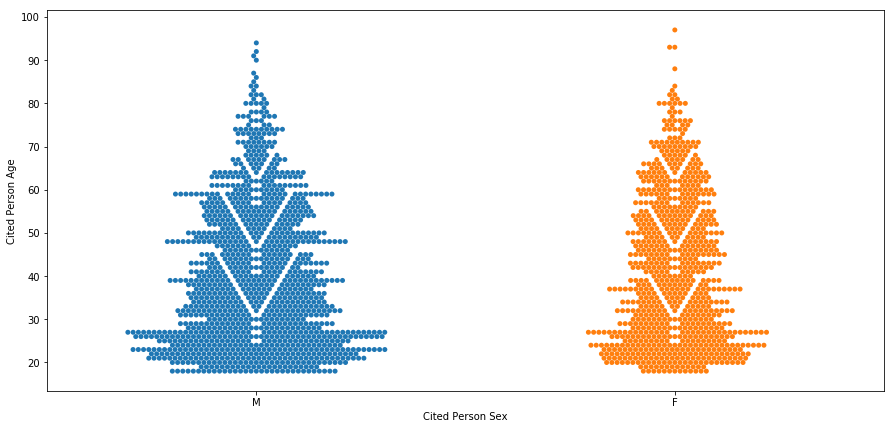

In [13]:
sns.swarmplot(x=fail_to_obey['Cited Person Sex'], 
                y=fail_to_obey['Cited Person Age'])

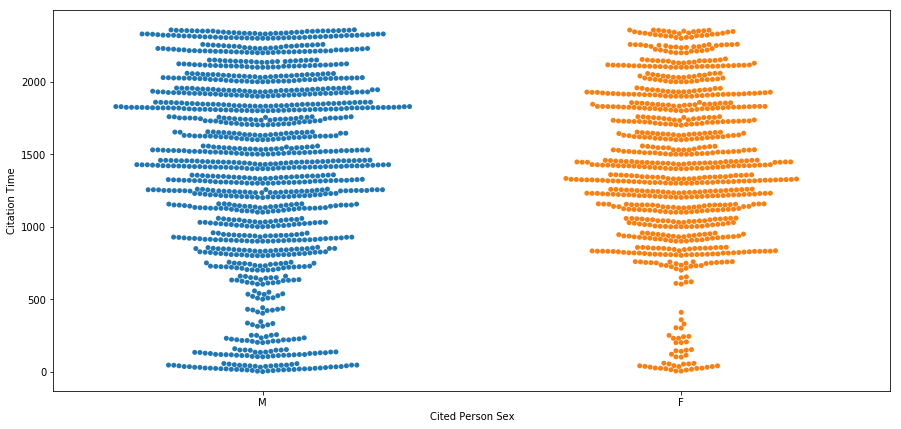

In [14]:
sns.swarmplot(x=fail_to_obey['Cited Person Sex'], 
                y=fail_to_obey['Citation Time'])

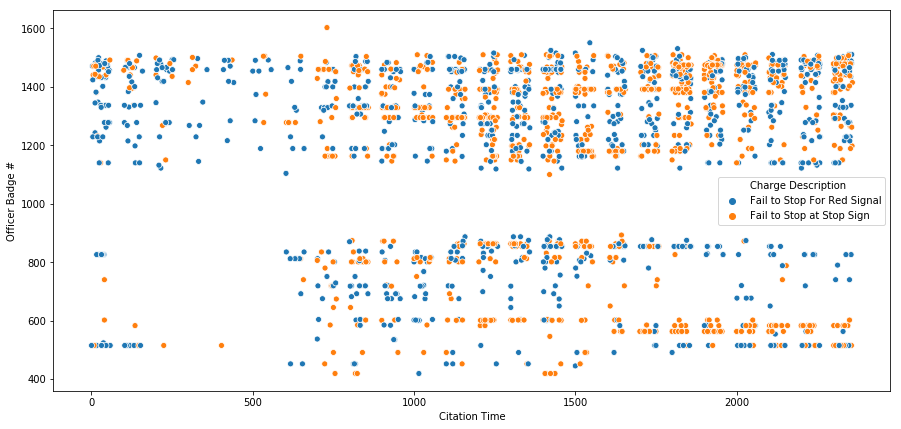

In [15]:
sns.scatterplot(x=fail_to_obey['Citation Time'], 
                y=fail_to_obey['Officer Badge #'], 
                hue=fail_to_obey['Charge Description'])

# some officers are clearly focused on patrolling stop signs
# whereas stop lights seem to be enforced by officers in the normal course of business
# there is less of a predictable pattern to the enforcement of stop lights, vs stop signs